In [24]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from ml_field_experiments.effect_heterogeneity.methods import grf, nn, svm, gp

params = {}

sns.set_theme(palette="colorblind", rc=params)

# Welfare Effects of Social Media Demo

In this demo we will use the [The Welfare Effects of Social Media](https://www.aeaweb.org/articles?id=10.1257%2Faer.20190658&utm_campaign=Johannes) data to illustrate some of the analytic tools we have discussed thus far in class.

## Preparing the Data  <a class="anchor" id="data"></a>

First we will load the data as a pandas DataFrame

In [36]:
data_path = Path("../data") / "final_data.csv"
df = pd.read_csv(data_path, index_col=0, low_memory=False)
df.head()

,status_x,progress_midline,durationinseconds_midline,finished_x,recordeddate_x,responseid,externalreference,distributionchannel,userlanguage,fb_activepassive2,...,leisure_offline_nn,leisure_offline_b_nn,leisure_diverse_nn,leisure_diverse_b_nn,index_sub_time,index_sub_time_b,index_swb,index_swb_b,index_social,index_social_b
0,ip address,100.0,1667.0,True,2018-10-11 08:18:38,r_3ehx91518oz2nng,NaN,email,en,-1.003378,...,5.0,5,1.0,1,-1.082120,-1.356541,-0.651342,-0.055994,0.214641,0.997544
1,ip address,31.0,804.0,False,2018-10-12 23:48:08,r_c1huza49qdja62t,NaN,email,en,-0.052321,...,NaN,5,NaN,0,NaN,2.417295,-3.197087,-0.171828,NaN,0.279153
2,ip address,100.0,511.0,True,2018-10-11 08:48:59,r_3owo9hgofnrayth,NaN,email,en,-1.552065,...,1.0,4,0.0,0,-0.907456,1.075118,0.203051,-0.114937,-1.342148,-0.831115
3,ip address,100.0,1238.0,True,2018-10-11 05:00:55,r_9ujeq7iswe0gvgt,NaN,email,en,0.276891,...,NaN,6,NaN,0,NaN,0.306184,3.152570,2.290298,NaN,0.529199
4,ip address,100.0,1341.0,True,2018-10-11 10:18:38,r_1lzooskjscdurxq,NaN,email,en,1.045053,...,4.0,5,0.0,0,1.271759,-0.052251,2.023563,1.596929,-0.443785,0.145858


In this example, we are going to look at the intention-to-treat (ITT) and the contidional average intention-to-treat (CITT) effects of deactivation from Facebook on subjective well being.
The statistical estimand for the ITT is defined as,
$$\text{ITT} \coloneqq E[Y \mid T=1] - E[Y \mid T=0],$$
and the statistical estimand for the CITT is defined as,
$$\text{CITT}(x) \coloneqq E[Y \mid T=1, X=x] - E[Y \mid T=0, X=x],$$
where the outcome is denoted as $Y$, treatment is denoted $T$, and the pretreatment covariates are denoted as $X$.
If there were perfect compliance in this study, then the ITT and CITT would be equivalent to the familiar average treatment effect (ATE) and conditional average treatment effect (CATE), respectively.

Let's grab the outcome and treatment variables from the dataframe

In [37]:
# Our outcome is the index for subjective well being.
# We will focus on the main sample and drop rows of the data that contain nan values for the outcome.
in_sample = df["sample_main"] == 1
this_sample = in_sample & df.loc[in_sample, "index_swb"].notna()

# The outcome variable as a numpy array
y = df.loc[this_sample, "index_swb"].values

# The treatment variable as a numpy array
t = df.loc[this_sample, "T"].values

Now let's grab the pretreatment covariates from the dataframe

In [38]:
# The continuous covariates are
continuous_covariates = [
    "age",  # Age
    "hhld_inc",  # Household Income
    "educyears",  # Years of Education
    "repdem",  # Scale of party identification [0 (dem), 1 (rep)]
    "fb_active",  # Active minutes on FB
    "fb_activepassive",  # Active and passive minutes on FB
    "fb_minutes_prescreen",  # FB minutes at pre-screen
]
# We standardize them by subtracting their mean values and dividing by theur standard deviations.
X_cont = df.loc[this_sample, continuous_covariates].copy().astype("float32")
X_cont = (X_cont - X_cont.mean(0)) / (X_cont.std(0) + 1e-6)

# The binary covariates are
binary_covariates = [
    "female",  # Identify as female
    "male",  # Identify as male
    "white",  # Identify as white
    "black",  # Identify as Black
    "republican",  # Identify as republican
    "democrat",  # Identify as democrat
    "hhld_inc_under50",  # Household income under $50,000
    "college",  # [Attended/Graduated] College
    "ageunder30",  # Under 30 years old
    "agenda",  # Believes experimenters have an agenda
    "opinion_b",  # Has positive opinion of facebook
    "news_fb",  # News from facebook above median
    "minutes_fb",  # Minutes on facebook above median
    "age_dummy",  # Age above median
]
# We preprocess them by mapping 0 to -1 and 1 to 1.
X_bin = df.loc[this_sample, binary_covariates].copy().astype("float32")
X_bin = 2 * X_bin - 1
X_bin = X_bin.fillna(0)

# In addition to the above, we will include baseline measures of the
# component variables of the subjective well being index
outcome_names = {
    "swb_happy": "Happiness",
    "swb_swl": "Life satisfaction",
    "swb_lns": "Loneliness",
    "swb_eurhappsvy_4": "Depressed",
    "swb_eurhappsvy_5": "Anxious",
    "swb_eurhappsvy_6": "Absorbed",
    "swb_eurhappsvy_7": "Bored",
    "happy_sms_summary": "SMS happiness",
    "pos_emotion_sms_summary": "SMS positive emotion",
    "lonely_sms_summary": "SMS not lonely",
}
# Get outcome baselines
baselines = [f"index_swb_b"]
# baselines = []
for k in outcome_names.keys():
    baselines.append(f"{k}_b")

# We also standardize the baseline outcome measures
X_baseline = df.loc[this_sample, baselines].copy().astype("float32")
X_baseline = (X_baseline - X_baseline.mean(0)) / (X_baseline.std(0) + 1e-6)

# Finally we get the covariates as a numpy array
x = np.hstack(
    [
        X_baseline.values,
        X_cont.values,
        X_bin.values,
    ]
)

Let's quickly verify that everyone has the right shapes

In [39]:
print(x.shape, t.shape, y.shape)

(1660, 32) (1660,) (1660,)


Looks great. For the pre-treatment covariates, x, we have 1660 total observations, and there are 31 different values. Both the treatment, t, and outcome, y, also have 1660 observations.

## Average Treatment Effects <a class="anchor" id="itt"></a>
Now we can look at estimating the ITT effect of deactivating from Facebook on subjective well being.
First we will use difference in means, adjusted regression, and interated regression.
### Regression Approaches
#### Difference In Means (DIM)
We can get a DIM estimate for the ITT by regressing the outcome on the treatment.

In [40]:
m = sm.OLS(
    y,
    sm.add_constant(t.reshape(-1, 1)),
)
results = m.fit().get_robustcov_results()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8216
Date:                Sun, 10 Mar 2024   Prob (F-statistic):              0.365
Time:                        15:14:34   Log-Likelihood:                -2336.5
No. Observations:                1660   AIC:                             4677.
Df Residuals:                    1658   BIC:                             4688.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.551e-17      0.030  -1.82e-15      1.000      -0.060       0.060
x1             0.0457      0.050      0.906      0.365      -0.053       0.145
==============================================================================
Omnibus:                       30.825   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.964
Skew:                          -0.297   Prob(JB):                     3.12e-07
Kurtosis:                       2.716   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

We can get the estimated ITT from the coeficient value under the row x1.

We see that the estimated value is 0.0457, but that the result is not significant as the p-value (P>|t|) is quite high at 0.369.

#### Regression Adjusted
We can get a Regression Adjusted estimate for the ITT by regressing the outcome on both the treatment and the pre-treatment covariates.

In [41]:
m = sm.OLS(
    y,
    sm.add_constant(np.hstack([t.reshape(-1, 1), x])),
)
results = m.fit().get_robustcov_results()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     52.65
Date:                Sun, 10 Mar 2024   Prob (F-statistic):          2.46e-229
Time:                        15:14:35   Log-Likelihood:                -1744.1
No. Observations:                1660   AIC:                             3556.
Df Residuals:                    1626   BIC:                             3740.
Df Model:                          33                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0124      0.053     -0.235      0.814      -0.116       0.091
x1             0.0696      0.037      1.890      0.059      -0.003       0.142
x2             0.5636      0.284      1.985      0.047       0.007       1.120
x3             0.1261      0.060      2.117      0.034       0.009       0.243
x4             0.0362      0.051      0.716      0.474      -0.063       0.136
x5             0.0754      0.029      2.641      0.008       0.019       0.131
x6             0.0028      0.031      0.090      0.928      -0.057       0.063
x7            -0.0476      0.105     -0.454      0.650      -0.253       0.158
x8            -0.0922      0.091     -1.015      0.310      -0.271       0.086
x9            -0.0713      0.112     -0.638      0.524      -0.291       0.148
x10            0.1548      0.041      3.736      0.000       0.074       0.236
x11           -0.0750      0.082     -0.911      0.362      -0.237       0.086
x12            0.0353      0.039      0.915      0.360      -0.040       0.111
x13            0.0030      0.032      0.095      0.924      -0.059       0.065
x14            0.0050      0.023      0.222      0.824      -0.039       0.049
x15           -0.0245      0.037     -0.664      0.507      -0.097       0.048
x16            0.0084      0.049      0.170      0.865      -0.088       0.105
x17            0.0024      0.021      0.114      0.909      -0.039       0.044
x18            0.0083      0.023      0.366      0.714      -0.036       0.053
x19           -0.0063      0.024     -0.258      0.796      -0.054       0.041
x20            0.0672      0.087      0.775      0.439      -0.103       0.237
x21            0.0389      0.087      0.447      0.655      -0.132       0.210
x22            0.0053      0.021      0.260      0.795      -0.035       0.046
x23           -0.0149      0.045     -0.333      0.739      -0.102       0.073
x24            0.0317      0.044      0.712      0.476      -0.056       0.119
x25            0.0107      0.037      0.287      0.774      -0.063       0.084
x26           -0.0206      0.025     -0.835      0.404      -0.069       0.028
x27            0.0553      0.036      1.524      0.128      -0.016       0.127
x28           -0.0205      0.037     -0.554      0.579      -0.093       0.052
x29           -0.0060      0.018     -0.324      0.746      -0.042       0.030
x30           -0.0071      0.018     -0.396      0.692      -0.042       0.028
x31           -0.0182      0.018     -1.002      0.316      -0.054       0.017
x32           -0.0616      0.022     -2.742      0.006      -0.106      -0.018
x33           -0.0250      0.039     -0.634      0.526      -0.102       0.052
==============================================================================
Omnibus:                       12.221   Durbin-Watson:                   1.957
Pr

We again can get the estimated ITT from the coeficient value under the row x1.

We see that the estimated value is 0.0696 and that the standard error of the estimate is lower at 0.036, but that the result may not yet be significant as the p-value (P>|t|) is 0.055.

#### Regression Interacted
We can get a Regression Adjusted estimate for the ITT by regressing the outcome on the treatment, the pre-treatment covariates, and treatment by covariate interactions.

In [42]:
m = sm.OLS(
    y,
    sm.add_constant(np.hstack([t.reshape(-1, 1), x, t.reshape(-1, 1) * (x - x.mean(0))])),
)
results = m.fit().get_robustcov_results()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     29.01
Date:                Sun, 10 Mar 2024   Prob (F-statistic):          2.71e-222
Time:                        15:14:37   Log-Likelihood:                -1723.2
No. Observations:                1660   AIC:                             3578.
Df Residuals:                    1594   BIC:                             3936.
Df Model:                          65                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0389      0.061     -0.635      0.526      -0.159       0.081
x1             0.0673      0.037      1.842      0.066      -0.004       0.139
x2             0.8703      0.355      2.448      0.014       0.173       1.567
x3             0.2089      0.075      2.774      0.006       0.061       0.357
x4            -0.0157      0.064     -0.244      0.807      -0.142       0.111
x5             0.0487      0.036      1.367      0.172      -0.021       0.119
x6            -0.0077      0.040     -0.195      0.846      -0.085       0.070
x7            -0.1598      0.131     -1.221      0.222      -0.417       0.097
x8            -0.1719      0.114     -1.507      0.132      -0.396       0.052
x9            -0.1737      0.139     -1.248      0.212      -0.447       0.099
x10            0.1292      0.052      2.463      0.014       0.026       0.232
x11           -0.1828      0.102     -1.798      0.072      -0.382       0.017
x12            0.0010      0.049      0.021      0.984      -0.094       0.096
x13           -0.0448      0.041     -1.090      0.276      -0.125       0.036
x14           -0.0130      0.027     -0.477      0.633      -0.067       0.041
x15           -0.0541      0.046     -1.185      0.236      -0.144       0.035
x16            0.0731      0.060      1.223      0.221      -0.044       0.190
x17           -0.0030      0.026     -0.113      0.910      -0.054       0.048
x18           -0.0200      0.028     -0.711      0.477      -0.075       0.035
x19           -0.0101      0.030     -0.341      0.733      -0.068       0.048
x20            0.0303      0.082      0.368      0.713      -0.131       0.192
x21           -0.0028      0.083     -0.034      0.973      -0.165       0.160
x22            0.0062      0.025      0.243      0.808      -0.044       0.056
x23            0.0145      0.052      0.281      0.779      -0.087       0.116
x24           -0.0340      0.055     -0.623      0.533      -0.141       0.073
x25            0.0481      0.045      1.071      0.284      -0.040       0.136
x26           -0.0489      0.031     -1.575      0.115      -0.110       0.012
x27            0.0768      0.043      1.775      0.076      -0.008       0.162
x28           -0.0806      0.045     -1.781      0.075      -0.169       0.008
x29           -0.0121      0.022     -0.539      0.590      -0.056       0.032
x30            0.0010      0.022      0.044      0.965      -0.043       0.044
x31           -0.0328      0.022     -1.466      0.143      -0.077       0.011
x32           -0.0480      0.028     -1.695      0.090      -0.104       0.008
x33           -0.0078      0.048     -0.164      0.870      -0.101       0.086
x34           -0.5697      0.542     -1.052      0.293      -1.632       0.493
x35           -0.1759      0.114     -1.536      0.125      -0.400       0.049
x3

We again can get the estimated ITT from the coeficient value under the row x1.

We see that the estimated value is a touch lower at 0.0673 and that the standard error of the estimate is the same at 0.037, thus the p-value is a bit higher at 0.066.

### Machine Learning Approaches
Here we will look at using two machine learning approaches (GRF and SVM) to estimate the ITT using the framework proposed in [Fisher-Schultz Lecture: Generic Machine Learning Inference on Heterogenous Treatment Effects in Randomized Experiments](https://arxiv.org/abs/1712.04802)

#### GRF

In [43]:
results_grf = grf.GRFTest(
    w_hat=1 / 3,
    num_estimators=2000,
    verbose=True,
).run(x, t, y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     380.2
Date:                Sun, 10 Mar 2024   Prob (F-statistic):          2.44e-232
Time:                        15:14:42   Log-Likelihood:                -1798.8
No. Observations:                1660   AIC:                             3608.
Df Residuals:                    1655   BIC:                             3635.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2913      0.235      1.240      0.2

Excuse the poor naming of variables, but we can get the estimated ITT from the coeficient value under the row x3

We see that the estimated value is a higher than for the regression approaches at 0.0780 and that the standard error of the estimate is the same at 0.037. Note now that the p-value is now 0.036, which is below the common threshold of 0.05 for significance.

#### SVM

In [44]:
results_svm = svm.SVRTest(
    w_hat=1 / 3,
    verbose=True,
).run(x, t, y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     347.4
Date:                Sun, 10 Mar 2024   Prob (F-statistic):          3.43e-217
Time:                        15:14:44   Log-Likelihood:                -1846.1
No. Observations:                1660   AIC:                             3702.
Df Residuals:                    1655   BIC:                             3729.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0058      0.021     -0.269      0.7

Again, we can get the estimated ITT from the coeficient value under the row x3

We see that the estimated value is 0.0856 and that the standard error of the estimate is 0.038. The p-value is 0.025, which is again below the common threshold of 0.05 for significance.

### Summary
We summarize the findings of each method in the following table.
We see that each method yields quite different results, and only the two ML methods seem to yield significant results.
Interesting...

In [49]:
df_summary = pd.DataFrame(
    [
        ["DIM", 0.0457, 0.050, 0.365],
        ["OLS-Adj", 0.0696, 0.037, 0.059],
        ["OLS-Inter", 0.0673, 0.037, 0.066],
        ["GRF", 0.0780, 0.037, 0.036],
        ["SVM", 0.0856, 0.038, 0.025],
    ],
    columns=["Method", "ITT", "Standard Error", "p-Value"],
)
df_summary

,Method,ITT,Standard Error,p-Value
0,DIM,0.0457,0.050,0.365
1,OLS-Adj,0.0696,0.037,0.059
2,OLS-Inter,0.0673,0.037,0.066
3,GRF,0.0780,0.037,0.036
4,SVM,0.0856,0.038,0.025


## Effect Heterogeneity <a class="anchor" id="citt"></a>

We can use the previous two Machine Learning tests to assess effect heterogeneity.

The x4 coefficients are the $\beta_2$ estimates of the omnibus GRF test for heterogeneity presented in [Fisher-Schultz Lecture: Generic Machine Learning Inference on Heterogenous Treatment Effects in Randomized Experiments](https://arxiv.org/abs/1712.04802). We see from their corresponding p-values (0.427 and 0.079) that it does not seem that we have substantial evidence for effect heterogeneity here. 

Note that if you rerun these tests you will see different results for the p-values, which is unfortunate.

So is there heterogeneity?

Who knows, but let's look at some lowess plots of the predicted CITT against the continuous covariates for fun :)

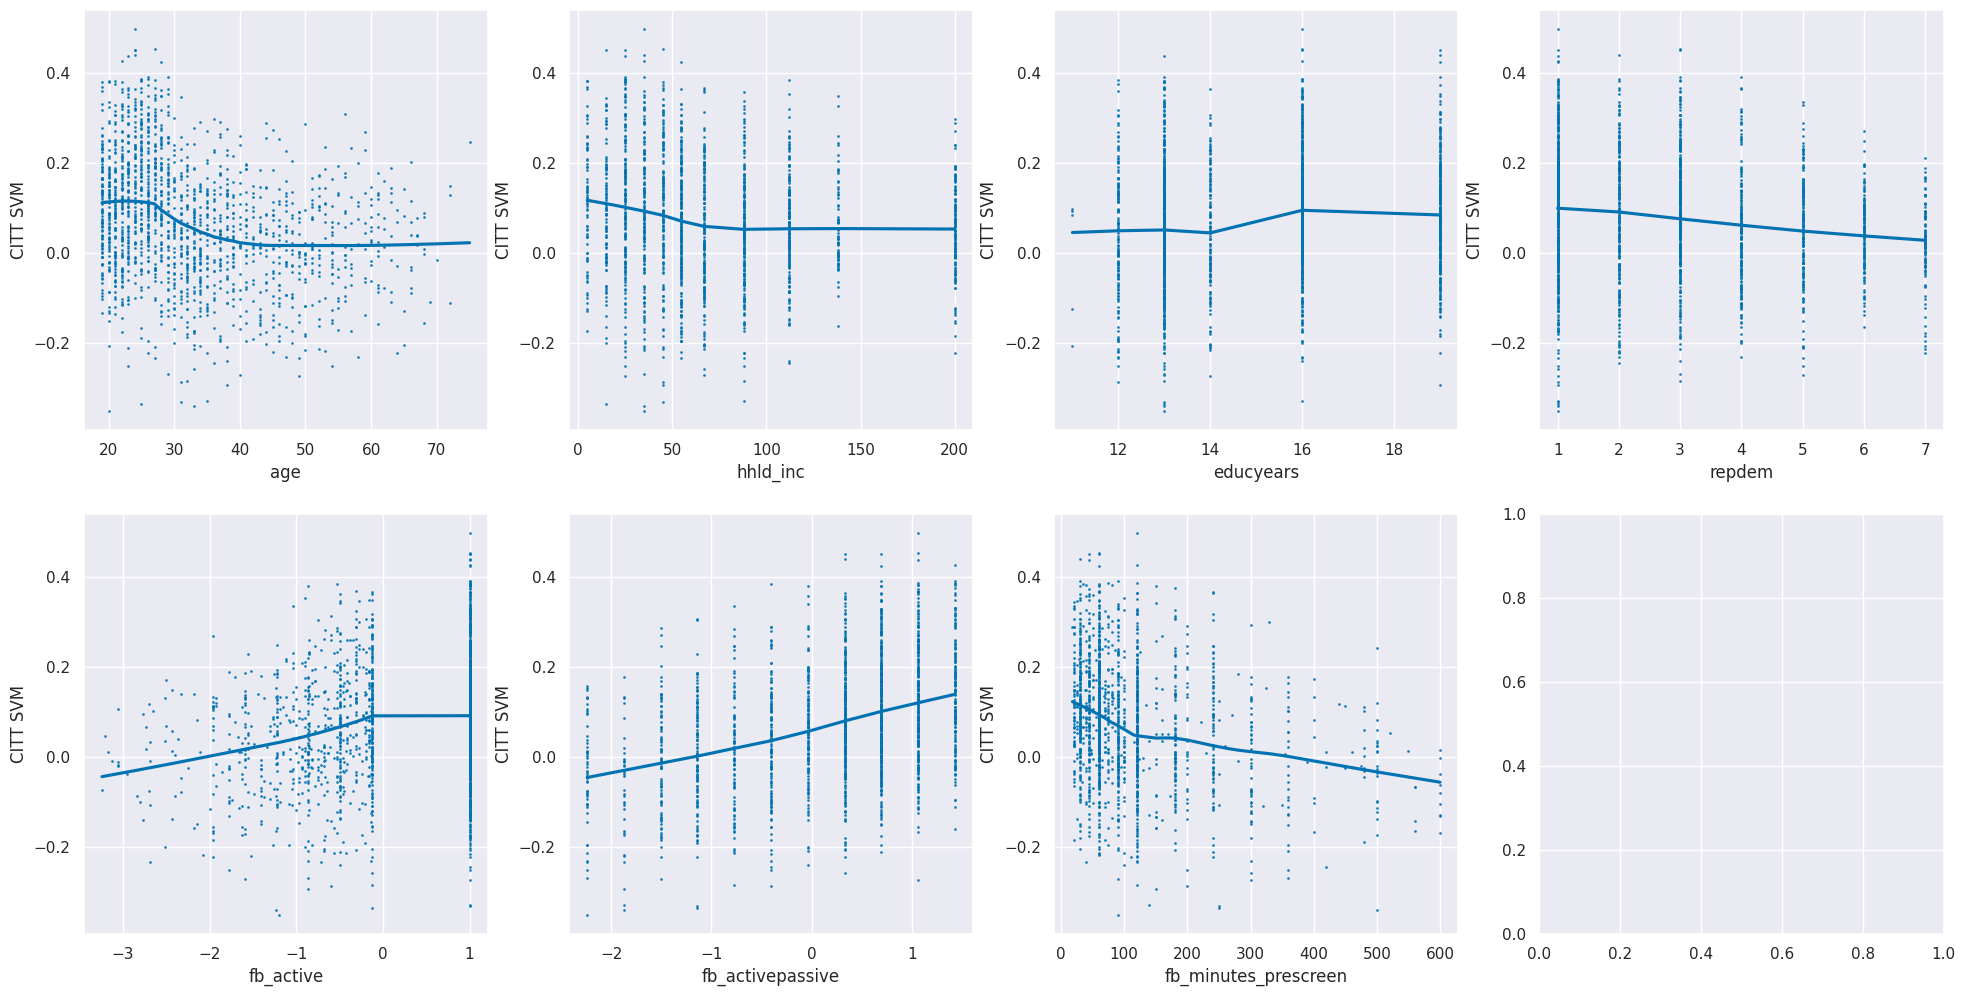

In [77]:
df_het = df.loc[this_sample, continuous_covariates].copy()
df_het["CITT GRF"] = results_grf["CATE"]
df_het["CITT SVM"] = results_svm["CATE"]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))
axs = axs.flatten()
for i, column in enumerate(X_cont.columns):
    _ = sns.regplot(
        data=df_het,
        x=column,
        y="CITT SVM",
        lowess=True,
        scatter_kws={"s": 1},
        ax=axs[i],
    )